[EP03] EXPLORATION_IC3 : 어제 오른 내 주식, 과연 내일은?


   < 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다>
   



##목차##


(1) 시계열 데이터 준비

(2) 각종 전처리 수행

(3) 시계열 안정성 분석

(4) 학습, 테스트 데이터셋 생성

(5) 적정 ARIMA 모수 찾기

(6) ARIMA 모델 훈련과 테스트

(7) 다른 주식 종목 예측해 보기

(8) 회고

(9) 루브릭




1. 시계열의 안정성이 충분히 확인되었는가?

플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨



In [6]:
##(1)시계열 데이터 준비##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/문서/GitHub/Exploration/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-01,76700.0,77100.0,75900.0,76800.0,75241.617188,16114775
1,2021-09-02,76800.0,76800.0,75700.0,76000.0,74457.867188,15347486
2,2021-09-03,76400.0,76700.0,76000.0,76600.0,75045.695313,12096419
3,2021-09-06,76800.0,77600.0,76600.0,77300.0,75731.476563,12861180
4,2021-09-07,77100.0,77100.0,75900.0,76100.0,74555.828125,13239401


In [7]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-01,76700.0,77100.0,75900.0,76800.0,75241.617188,16114775
2021-09-02,76800.0,76800.0,75700.0,76000.0,74457.867188,15347486
2021-09-03,76400.0,76700.0,76000.0,76600.0,75045.695313,12096419
2021-09-06,76800.0,77600.0,76600.0,77300.0,75731.476563,12861180
2021-09-07,77100.0,77100.0,75900.0,76100.0,74555.828125,13239401


In [8]:
##(2)각종 전처리 수행##

ts1 = df['Close']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2021-09-01    76800.0
2021-09-02    76000.0
2021-09-03    76600.0
2021-09-06    77300.0
2021-09-07    76100.0
Name: Close, dtype: float64

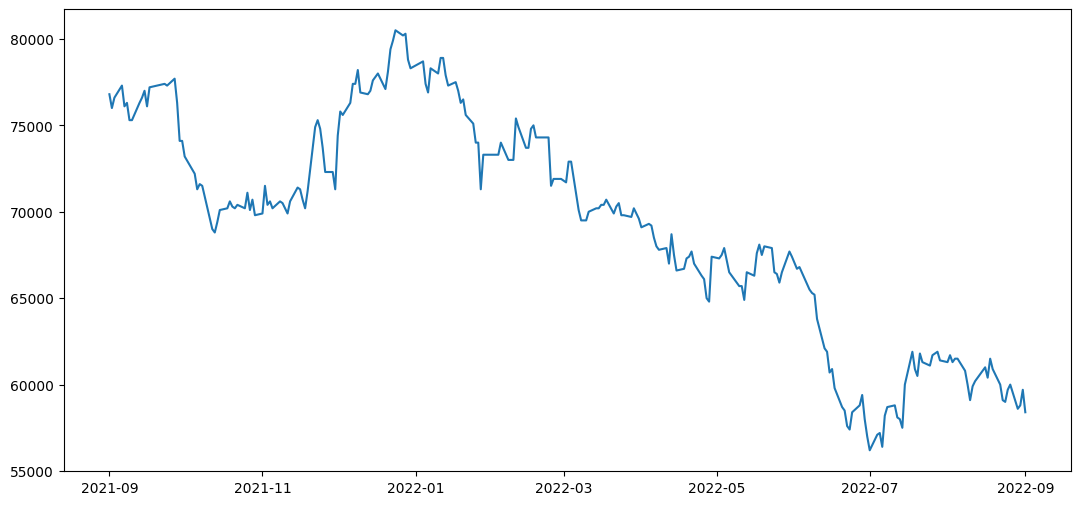

In [9]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

In [12]:
# 결측치 여부 확인
# 1)결측치가 있는 데이터를 모두 삭제(drop)하거나, 2)결측치 양옆의 값들을 이용해서 적절히 보간(interpolate) 대입해 주는 방법이 있습니다. 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식인 거죠. 이번 경우라면 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 보간하는 방법
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치가 있는 데이터를 모두 삭제(drop)

결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

Series([], Name: Close, dtype: float64)


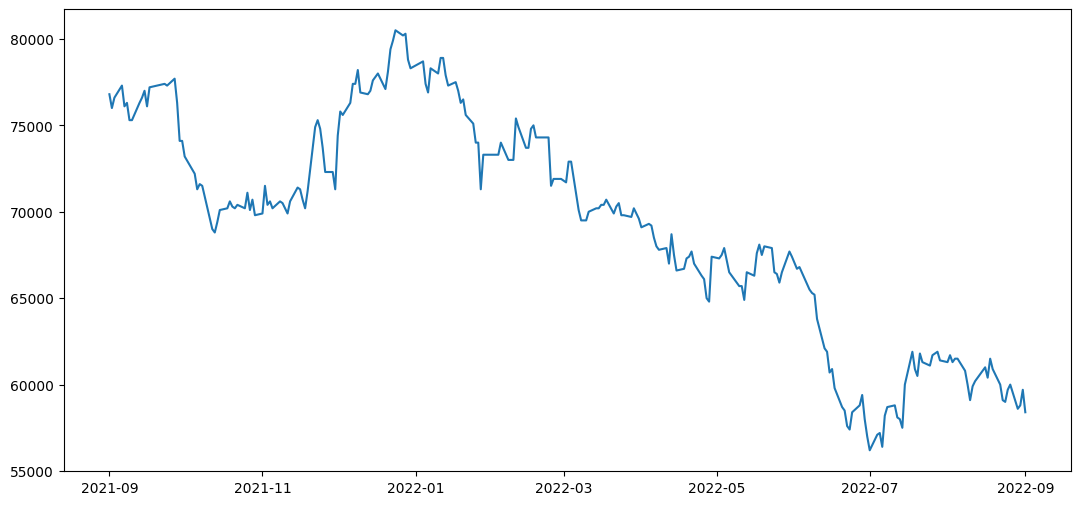

In [13]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

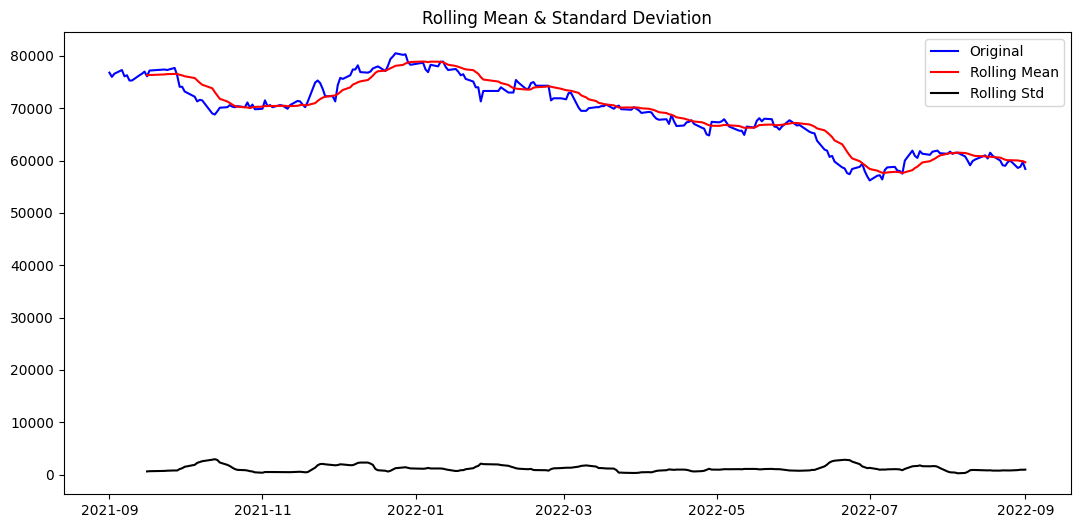

In [15]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts1, window=12)

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다.